Evaluate Model

---

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from tqdm import tqdm

# Open file
import os
import PIL
import cv2
from os import listdir
from random import shuffle

# Model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,f1_score

In [2]:
def create_label(word_label):
    ''' 
        Input : subdirectories path have nane file with class label 
        Return : number of classes label of each class 
    '''
    if word_label == "cocci":
        return 0
    elif word_label == "healthy":
        return 1
    elif word_label == "ncd":
        return 2
    elif word_label == "salmo":
        return 3

In [3]:
def created_dataset(DIR):
    '''
        Input : directories file have image file to want label   
        Return : dataframe of arrary image (RGB-3D shape) follow by img_height and img_width and label of each classes image 
    '''
    created_dataset = []
    for labels_c in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, labels_c)
        for file in listdir(path):
            img_data = cv2.imread(path+ "/" + file) 
            img_data = cv2.resize(img_data, (img_height , img_width))
            img_data = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)
            created_dataset.append([np.array(img_data), create_label(labels_c)])
    shuffle(created_dataset)
    return pd.DataFrame(created_dataset, columns=["picture","labels"])

In [4]:
def load_model(model_path):
    '''
        Input : subdirectories of model 
        Return : model of keras api with not complie 
    '''
    model = tf.keras.models.load_model(model_path, compile = False)
    return model

In [5]:
# Create function plot graph
def plot_graph(history_model, finetune=False, initial_epochs=0):
    ''' 
        Input : Model_values of keras.callbacks.History
        Return : Graph of Loss funtion and Mean squared error between training dataset and testing dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_model['loss'], label='Training Loss');
    plt.plot(history_model['val_loss'], label='Testing Loss');
    if finetune==True:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_model['accuracy'], label='Training Accuracy')
    plt.plot(history_model['val_accuracy'], label='Validation Accuracy')
    if finetune==True:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

In [6]:
def get_metric(model, X,  y_actual, name_model=None):
    '''
        Input : model = model of keras api 
                X = array of image follow by reshape and rescale fit for model input 
                y_actual = label of each image(X)
                name_model = str name of model want to show 
        Return : ConfusionMatrixDisplay, accuracy_score and size of model 
    '''
    prods_softmax = model.predict(X)
    y_preds = np.array([np.where(v == v.max())[0][0] for v in prods_softmax])
    print(f"Model : {name_model}")
    print("-"*50)
    labels = ['cocci', 'healthy', 'ncd', 'salmo']
    cm = confusion_matrix(y_actual, y_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap=plt.cm.Blues);
    print(classification_report(y_actual, y_preds, target_names=labels))
    print(f"Accuracy score: {round(accuracy_score(y_actual, y_preds),2)}")
    print(f"F1 score average: {round(f1_score(y_actual, y_preds, average = 'macro'),2)}")

In [7]:
def get_values_model(X , y_actual, history_model, model, name_model="", model_path=None):
 
    ''' Show the overall metric model
        Parameter : X = array of image follow by reshape and rescale fit for model input
                    y_actual : label of each image(X)
                    history_model : model_values of keras.callbacks.History
                    model : model of keras api 
                    name_model : str name of model want to show
                    model_path : subdirectories of model 
        Return : Add value of model to set of 
                model_name, loss, val_loss, accuracy, val_accuracy, F1_score, size_mb, number_params, input_size   
    '''
    
    # Predict model 
    prods_softmax = model.predict(X)
    y_preds = np.array([np.where(v == v.max())[0][0] for v in prods_softmax])
    
    # Add values
    model_name.append(name_model)
    loss.append(round(history_model.iloc[-1]["loss"],2))
    val_loss.append(round(history_model.iloc[-1]["val_loss"],2))
    accuracy.append(round(history_model.iloc[-1]["accuracy"],2))
    val_accuracy.append(round(history_model.iloc[-1]["val_accuracy"],2))
    F1_score.append(round(f1_score(y_actual, y_preds, average = 'macro'),2))
    size_mb.append(round(os.stat(model_path).st_size/1_048_576 , 2))
    number_params.append(f'{model.count_params():,}')
    input_size.append(model.input_shape)

01. Open Dataset
   ---

In [8]:
# Open path file of dataset 
dataset_path_new = "../dataset_train_valid_test/"

valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

Preprocessing Image Dataset

---

In [9]:
# Create dataframe of validation and testing dataset 
# for model CNN and mobileNetV2
# Using input image size 128x128
img_height=128
img_width=128
df_valid = created_dataset(DIR=valid_dir)
df_test = created_dataset(DIR=test_dir)

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


In [10]:
# Recheck
df_valid.head()

,picture,labels
0,"[[[155, 154, 150], [141, 141, 139], [153, 153,...",0
1,"[[[102, 84, 60], [119, 97, 76], [159, 135, 110...",0
2,"[[[168, 155, 128], [188, 168, 130], [154, 137,...",3
3,"[[[62, 38, 19], [60, 38, 23], [52, 33, 20], [2...",0
4,"[[[105, 74, 32], [106, 75, 28], [131, 102, 41]...",0


In [11]:
# Recheck
df_test.head()

,picture,labels
0,"[[[143, 140, 135], [159, 158, 153], [164, 165,...",2
1,"[[[155, 165, 148], [183, 186, 168], [199, 192,...",3
2,"[[[195, 177, 153], [200, 183, 163], [217, 201,...",0
3,"[[[145, 144, 142], [134, 134, 133], [171, 172,...",0
4,"[[[104, 116, 117], [104, 119, 117], [104, 122,...",3


In [12]:
# Define X and y for
X_valid = np.array([i for i in df_valid["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_valid = df_valid["labels"]
X_test = np.array([i for i in df_test["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_test = df_test["labels"]

In [13]:
# Check shape before prediction with model
X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((834, 128, 128, 3), (834,), (813, 128, 128, 3), (813,))

In [14]:
# Check class in y_valid
pd.Series(y_valid).value_counts(normalize=True).mul(100).sort_index(ascending=True)


labels
0    27.697842
1    31.654676
2     6.594724
3    34.052758
Name: proportion, dtype: float64

In [15]:
# Check class in y_test
pd.Series(y_test).value_counts(normalize=True).mul(100).sort_index(ascending=True)


labels
0    29.397294
1    28.905289
2     7.503075
3    34.194342
Name: proportion, dtype: float64

In [16]:
# Define labels dictionary of each class
labels_dict = {'cocci':0, 'healthy':1, 'ncd':2, 'salmo':3}

02. Baseline Model CNN
   ---

In [17]:
# path of model 
cnn_path = "../model/cnn/cnn_model.h5"

# load model 
cnn_model = load_model(model_path=cnn_path)

In [18]:
# check model summary
# 2,102,564 parameters
# Get file size in bytes for a given model
print(f"Size of model(MB): {(os.stat(cnn_path).st_size/1_048_576)}") # convert Bytes to MB

cnn_model.summary()

Size of model(MB): 24.10467529296875
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)     

27/27 [==============================] - 1s 27ms/step
Model : CNN Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.88      0.93      0.90       231
     healthy       0.92      0.83      0.87       264
         ncd       0.58      0.82      0.68        55
       salmo       0.91      0.89      0.90       284

    accuracy                           0.87       834
   macro avg       0.82      0.86      0.84       834
weighted avg       0.88      0.87      0.88       834

Accuracy score: 0.87
F1 score average: 0.84


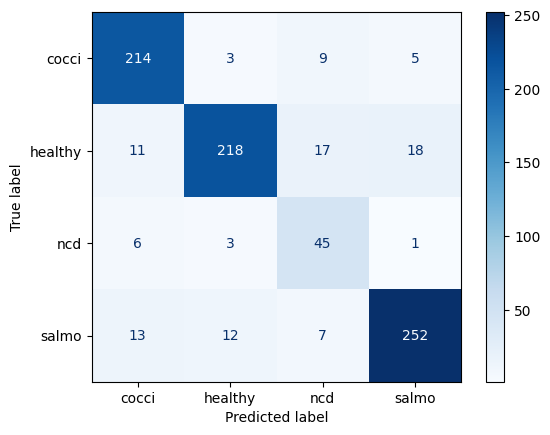

In [19]:
# See confusion_matrix of model 
get_metric(model=cnn_model,
          X=X_valid,
          name_model="CNN Model",
          y_actual=y_valid)

        loss  accuracy  val_loss  val_accuracy
20  0.332904  0.875097  0.498497      0.864508
21  0.317078  0.877417  0.517724      0.880096
22  0.306420  0.881671  0.459788      0.865707
23  0.314398  0.877932  0.521238      0.839329
24  0.327913  0.874452  0.537557      0.881295


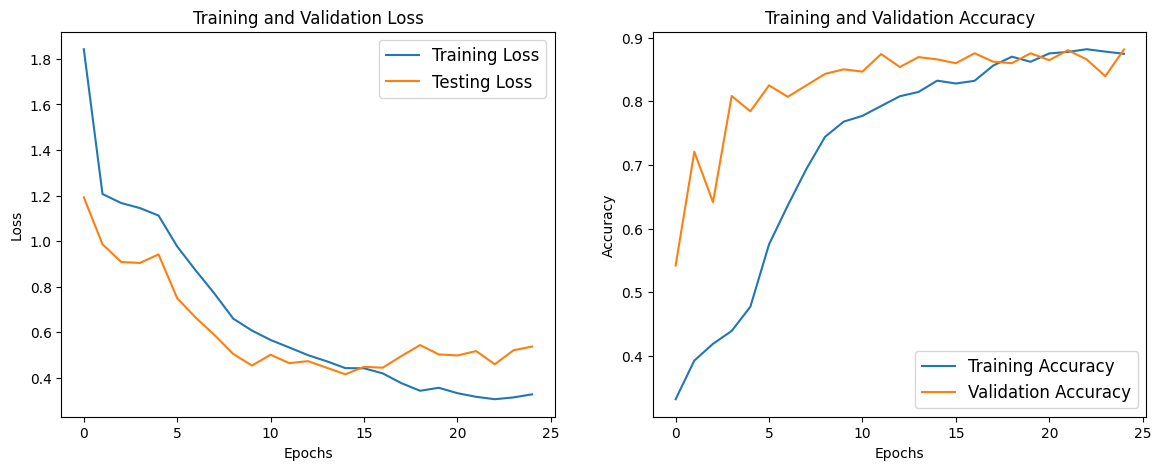

In [20]:
# See history of model  training
histort_cnn_model = pd.read_csv("../model/cnn/history_cnn16.csv", index_col="Unnamed: 0")
plot_graph(histort_cnn_model)
print(histort_cnn_model.tail())

03. Transfer Learning and Fine Tuning MobileNetV2 Model
   ---

In [21]:
# path of model 
mobnv2_tf_path = "../model/mobilenetV2/mobilenetv2.h5"
mobnv2_ft_path = "../model/mobilenetV2/mobilenetv2_ft.h5"

# load model 
mobnv2_tf_model = load_model(model_path=mobnv2_tf_path)
mobnv2_ft_model = load_model(model_path=mobnv2_ft_path)

In [22]:
# check model summary
# Total params: 2,263,108 parameters (equal params between transfer learning and fine tuning )
# Get file size in bytes for a given model
print(f"Size of MobileNetV2 transfer learning model(MB): {(os.stat(mobnv2_tf_path).st_size/1_048_576)}") # convert Bytes to MB
print(f"Size of MobileNetV2 fine tuning model(MB): {(os.stat(mobnv2_ft_path).st_size/1_048_576)}")


Size of MobileNetV2 transfer learning model(MB): 9.150642395019531
Size of MobileNetV2 fine tuning model(MB): 23.466957092285156


In [23]:
# check model summary
# Trainable params: 5,124
mobnv2_tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [24]:
# check model summary
# Trainable params: 1,866,564
mobnv2_ft_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

27/27 [==============================] - 5s 150ms/step
Model : MobileNetV2 Transfer Learning Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.95      0.96      0.95       231
     healthy       0.89      0.88      0.88       264
         ncd       0.74      0.89      0.81        55
       salmo       0.92      0.88      0.90       284

    accuracy                           0.90       834
   macro avg       0.87      0.90      0.89       834
weighted avg       0.90      0.90      0.90       834

Accuracy score: 0.9
F1 score average: 0.89


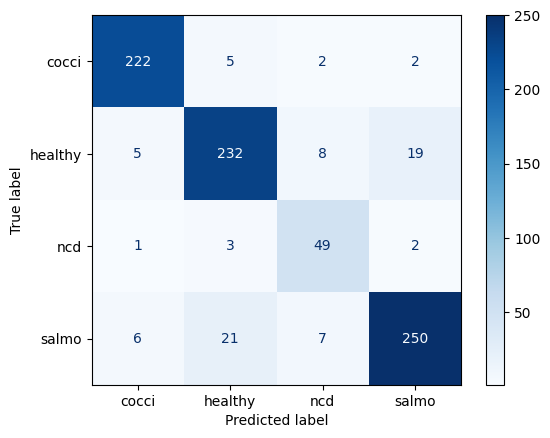

In [25]:
# See confusion_matrix of model 
get_metric(model=mobnv2_tf_model,
          X=X_valid,
          name_model="MobileNetV2 Transfer Learning Model",
          y_actual=y_valid)

27/27 [==============================] - 5s 154ms/step
Model : MobileNetV2 Fine Tuning Model
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.94      0.97      0.96       231
     healthy       0.95      0.83      0.89       264
         ncd       0.50      0.96      0.66        55
       salmo       0.96      0.88      0.92       284

    accuracy                           0.89       834
   macro avg       0.84      0.91      0.85       834
weighted avg       0.92      0.89      0.90       834

Accuracy score: 0.89
F1 score average: 0.85


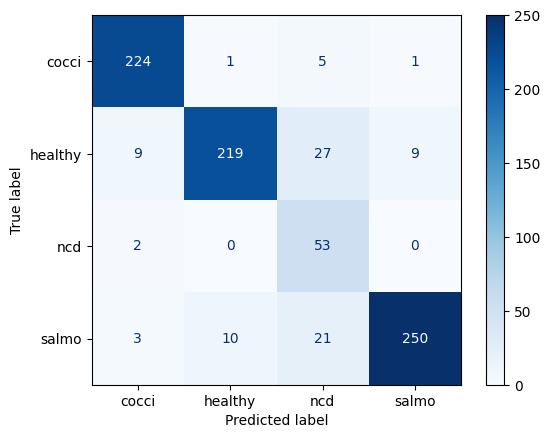

In [26]:
# See confusion_matrix of model 
get_metric(model=mobnv2_ft_model,
          X=X_valid,
          name_model="MobileNetV2 Fine Tuning Model",
          y_actual=y_valid)

In [28]:
# See history of model training both transfer learing or fine tuning
histort_mobnv2_tf_model = pd.read_csv("../model/mobilenetV2/history_mobilenetv2_tf.csv", index_col="Unnamed: 0")
histort_mobnv2_ft_model = pd.read_csv("../model/mobilenetV2/history_mobilenetv2_ft.csv", index_col="Unnamed: 0")
histort_mobnv2_model = pd.concat([histort_mobnv2_tf_model, histort_mobnv2_ft_model], ignore_index=True)
histort_mobnv2_model.tail()

,loss,accuracy,val_loss,val_accuracy
45,0.019611,0.992782,1.413011,0.902878
46,0.019864,0.992653,1.622145,0.883693
47,0.028925,0.990848,1.028265,0.872902
48,0.016203,0.994200,0.700468,0.923261
49,0.018436,0.993942,0.922258,0.905276


In [29]:
# See only history of model training transfer learing
histort_mobnv2_tf_model.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.086808,0.978087,0.274550,0.908873
21,0.082710,0.978861,0.287086,0.901679
22,0.081001,0.979376,0.284336,0.910072
23,0.075676,0.981181,0.283565,0.907674
24,0.073832,0.981439,0.285654,0.908873


In [33]:
# See only history of model training fine tuning
histort_mobnv2_ft_model.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.019611,0.992782,1.413011,0.902878
21,0.019864,0.992653,1.622145,0.883693
22,0.028925,0.990848,1.028265,0.872902
23,0.016203,0.994200,0.700468,0.923261
24,0.018436,0.993942,0.922258,0.905276


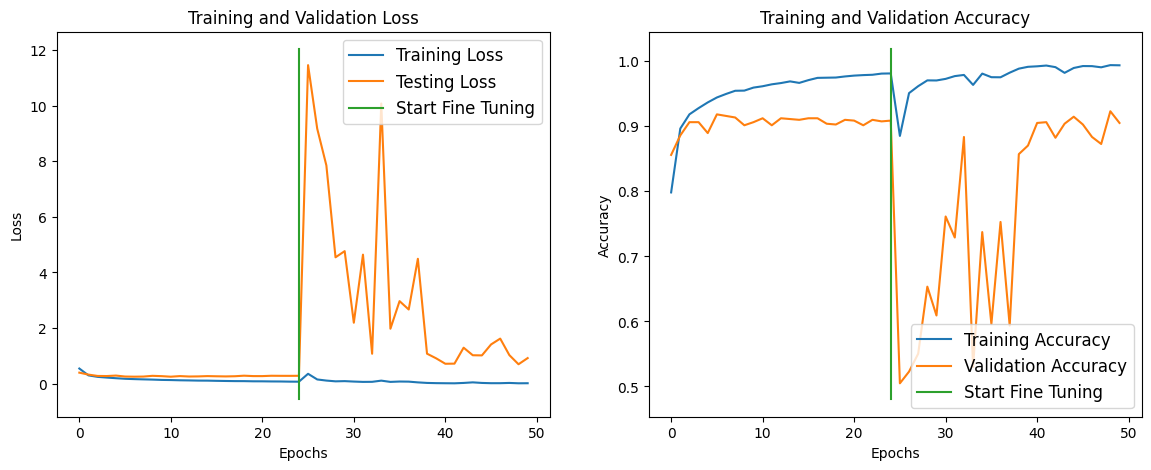

In [30]:
# Show graph
plot_graph(histort_mobnv2_model,finetune=True, initial_epochs=25)

---